# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [6]:
#def P1(num_examples=5):
### STUDENT START ###
def P1(num_examples=5):
    '''
    Returns the text of the first [num_examples] documents along with its labels.
    
    Parameters:
    -----------
    num_examples: integer greater than 0.
    
    Returns:
    --------
    Text of the first [num_examples] documents along with its labels.
    '''
    # order categories alphabetically. The original subsetting seem to have set in that way if we query the directory structure
    # with newsgroups_train.filenames
    categories.sort() # order categories alphabetically, 
    for label, text in zip(newsgroups_train.target[:num_examples],newsgroups_train.data[:num_examples]):
        print "Label:\n"+categories[label]+"\n"
        print "Text:\n"+text+"\n"

P1(2)        
### STUDENT END ###
#P1(2)

Label:
comp.graphics

Text:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label:
talk.religion.misc

Text:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

a.
Vocabulary size (unigram): 26879

Average number of non-zero features per example: 96.71

Fraction of non-zero entries: 0.0036

b.
The first string is 00 and the last string is zyxel

c.
Average number of non-zero features in the 4-word vocabulary: 0.27

d.
Vocabulary size (bigram, trigram char): 35478

e.
Vocabulary size (words that occur in at least 10 documents): 3064

f.
Number of words in the dev data that are missing from the training vocabulary: 4027
This constitutes 24.79% of the dev vocabulary and 14.98% of the training vocabulary.


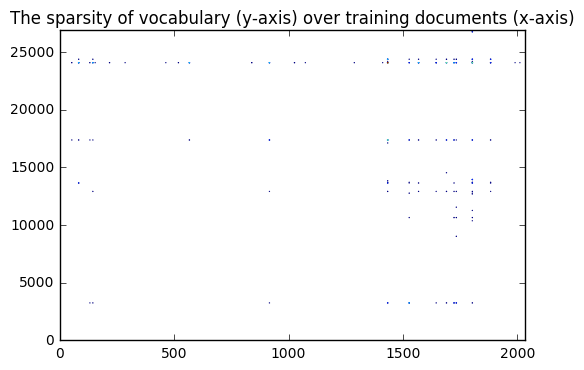

In [37]:
#def P2():
### STUDENT START ###
def P2():
    vectorizer = CountVectorizer()
    vectorized_train = vectorizer.fit_transform(train_data)
    # ----------------------- a --------------------------------- #
    # a.1. size of the vocabulary 
    vocabulary_size = vectorized_train.shape[1]
    # a.2. average number of non-zero features per example
    mean_non_zero_per_example = float(vectorized_train.nnz)/vectorized_train.shape[0]
    # a.3. Fraction of entries in the matrix that are non-zero
    fraction_non_zero_entries = float(vectorized_train.nnz)/(vectorized_train.shape[0]*vectorized_train.shape[1])
    print "a.\nVocabulary size (unigram): {vs}\n".format(vs=vocabulary_size)
    print "Average number of non-zero features per example: {nz}\n".format(nz=round(mean_non_zero_per_example,2))
    print "Fraction of non-zero entries: {fnz}\n".format(fnz=round(fraction_non_zero_entries,4))
    # ---------------------- b ------------------------------------ #
    # b.1. 0th and last feature strings
    first_last_string = [vectorizer.get_feature_names()[rank] for rank in [0,-1]]
    print "b.\nThe first string is {fs} and the last string is {ls}\n".format(fs=first_last_string[0],ls=first_last_string[1])
    # ---------------------- c ------------------------------------ #
    # c.1. Specify vocabulary with 4 words ["atheism", "graphics", "space", "religion"]
    vectorizer_4words = CountVectorizer(vocabulary= ["atheism", "graphics", "space", "religion"])      
    vectorized_4words_train = vectorizer_4words.fit_transform(train_data)    
    #      average number of non-zero features per example   
    mean_non_zero_per_example4 = float(vectorized_4words_train.nnz)/vectorized_4words_train.shape[0]
    # c.1.1 Alternatively, we could have calculated the average number of non-zero features for the 4 
    #       word vocabulary from the original
    #word_frequencies = [vectorized_train.getcol(vectorizer.vocabulary_.get(word)).nnz for word in
    #                                                                   ["atheism", "graphics", "space", "religion"]]
    #float(np.sum(word_frequencies))/vectorized_train.shape[0]
    print "c.\nAverage number of non-zero features in the 4-word vocabulary: {nz4}\n".format(nz4=round(mean_non_zero_per_example4,2))
    # --------------------- d -------------------------------------- #
    vectorizer_bigram_trigram = CountVectorizer(analyzer="char",ngram_range=(2,3))    
    vectorized_bigram_trigram_train = vectorizer_bigram_trigram.fit_transform(train_data)
    vocabulary_bigram_trigram_size = vectorized_bigram_trigram_train.shape[1]
    print "d.\nVocabulary size (bigram, trigram char): {vbt}\n".format(vbt=vocabulary_bigram_trigram_size)
    # ---------------------- e ------------------------------------ #
    vectorizer_min10 = CountVectorizer(min_df=10)    
    vectorized_min10_train = vectorizer_min10.fit_transform(train_data)
    vocabulary_min10_size = vectorized_min10_train.shape[1]
    print "e.\nVocabulary size (words that occur in at least 10 documents): {vs10}\n".format(vs10=vocabulary_min10_size)
    # ---------------------- f ------------------------------------- #
    vectorizer_dev =  CountVectorizer()
    vectorized_dev = vectorizer_dev.fit_transform(dev_data)
    vocabulary_size_dev = vectorized_dev.shape[1]
    strings_in_dev_not_in_train = set(vectorizer_dev.get_feature_names()).difference(vectorizer.get_feature_names())
    fraction_missing_dev = float(len(strings_in_dev_not_in_train))/vocabulary_size_dev
    fraction_missing_train = float(len(strings_in_dev_not_in_train))/vocabulary_size
    print "f.\nNumber of words in the dev data that are missing from the training vocabulary: {nwd}".format(nwd=len(strings_in_dev_not_in_train))
    print "This constitutes {fwd}% of the dev vocabulary and {fwt}% of the training vocabulary.".format(
                                                                  fwd=round(fraction_missing_dev*100,2),
                                                                  fwt=round(fraction_missing_train*100,2))
    # --------------------- extra: plot training vocabulary against training documents ---- #
    X, Y = np.meshgrid(np.arange(vectorized_train.shape[0]), np.arange(vectorized_train.shape[1]))
    plt.figure()
    CS = plt.contour(X, Y, np.transpose(vectorized_train.toarray()))
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('The sparsity of vocabulary (y-axis) over training documents (x-axis)')
P2()
### STUDENT END ###
#P2()

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [247]:
### STUDENT START ###
from sklearn.metrics import f1_score

def P3(): 
    def run_model(model,parameters,use_tfidf=True):
        if(use_tfidf):
            mod = Pipeline([('vect', CountVectorizer()),
                           ('tfidf', TfidfTransformer()),
                            ('clf', model),
                             ])
        else:
            mod = Pipeline([('vect', CountVectorizer()),
                            ('clf', model),
                             ])
        mod = mod.fit(train_data, train_labels)
        mod_predicted = mod.predict(dev_data)
        gs_mod = GridSearchCV(mod, parameters,scoring='f1_weighted')
        gs_mod = gs_mod.fit(train_data,train_labels)
        return gs_mod
    # --------------------- fit baseline ----------------------------------- #
    # instantiate k nearest neighbors classifier pipeline with 1 neighbor
    KN_1 = Pipeline([('vect', CountVectorizer()),
 #                    ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=1)),
                     ])
    # fit and predict KN-1 model, get F1 score
    KN_1 = KN_1.fit(train_data, train_labels)
    KN_1_predicted = KN_1.predict(dev_data)
    print "F1-score of 1-N-Neighbor: {f1s}".format(f1s=f1_score(dev_labels,KN_1_predicted,average='weighted'))   
    # --------------------- fit models ---------------------------------------- #
    # fit models with Tfidf
    KN = run_model(KNeighborsClassifier(),parameters={"clf__n_neighbors":np.arange(1,5)})
    MNB = run_model(MultinomialNB(),parameters={"clf__alpha":np.linspace(1e-9,5,30)})
    LR = run_model(LogisticRegression(),parameters={"clf__C":np.linspace(1e-9,5,30)})
    # fit models without Tfidf
    KN_wo_tfidf = run_model(KNeighborsClassifier(),parameters={"clf__n_neighbors":np.arange(1,5)},use_tfidf=False)
    MNB_wo_tfidf = run_model(MultinomialNB(),parameters={"clf__alpha":np.linspace(1e-9,5,30)},use_tfidf=False)
    LR_wo_tfidf = run_model(LogisticRegression(),parameters={"clf__C":np.linspace(1e-9,5,30)},use_tfidf=False)                     
    #------------------------- print reports ----------------------------------- #
    # if the best hyperparameter returned by grid search is on the right boundary, expand the interval
    print 'Using Tfidf:\n'
    print "Best cross-validated F1-score: {f1gs}, with {N}-N-Neighbors".format(f1gs=KN.best_score_,N=KN.best_params_)
    print "Best cross-validated F1-score: {f1gs}, with alpha={alpha} for Multinomial Naive Bayes".format(f1gs=
                                                    MNB.best_score_,alpha=MNB.best_params_)
    print "Best cross-validated F1-score: {f1gs}, with C={C} for Logistic Regression".format(f1gs=
                                                 LR.best_score_,C=LR.best_params_)
    print '\nWithout using Tfidf:\n'
    print "Best cross-validated F1-score: {f1gs}, with {N}-N-Neighbors".format(f1gs=KN_wo_tfidf.best_score_,N=KN_wo_tfidf.best_params_)
    print "Best cross-validated F1-score: {f1gs}, with alpha={alpha} for Multinomial Naive Bayes".format(f1gs=
                                                    MNB_wo_tfidf.best_score_,alpha=MNB_wo_tfidf.best_params_)
    print "Best cross-validated F1-score: {f1gs}, with C={C} for Logistic Regression".format(f1gs=
                                                 LR_wo_tfidf.best_score_,C=LR_wo_tfidf.best_params_)
    
P3()
### STUDENT END ###

F1-score of 1-N-Neighbor: 0.380503001853
Using Tfidf:

Best cross-validated F1-score: 0.285168712717, with {'clf__n_neighbors': 4}-N-Neighbors
Best cross-validated F1-score: 0.815462213423, with alpha={'clf__alpha': 1.0000000000000001e-09} for Multinomial Naive Bayes
Best cross-validated F1-score: 0.821556078144, with C={'clf__C': 4.3103448277241379} for Logistic Regression

Without using Tfidf:

Best cross-validated F1-score: 0.404788530555, with {'clf__n_neighbors': 1}-N-Neighbors
Best cross-validated F1-score: 0.82168854434, with alpha={'clf__alpha': 0.17241379406896551} for Multinomial Naive Bayes
Best cross-validated F1-score: 0.772044094962, with C={'clf__C': 0.17241379406896551} for Logistic Regression


ANSWER:

a. The K-Nearest Neighbors algorithm tries to compare each test example with the training examples and predicts their class according to the most similar training examples. However, if the feature space is very sparse, it will have trouble differentiating efficiently between the training examples.

b. Without Tfidf, logistic regression somewhat underperforms the Multinomial Naive Bayes. This can happen because of the large number of features compared to the number of training examples.

In [251]:
C_vals = np.linspace(1e-5,2,10)
mod = CountVectorizer()
for C_val in C_vals:
    lr = Pipeline([('vect', CountVectorizer()),
                     ('clf', LogisticRegression(C=C_val))
                     ])
    lr.fit(train_data, train_labels)
    lr_predict = lr.predict(dev_data)
    print 'C={C_val}'.format(C_val=round(C_val,2)),[round(sum(lr.named_steps['clf'].coef_[category_num]**2),2)
                                                                          for category_num in range(4)]

C=0.0 [0.0, 0.0, 0.0, 0.0]
C=0.22 [54.3, 46.32, 53.69, 46.66]
C=0.44 [93.99, 76.6, 91.0, 81.4]
C=0.67 [126.44, 100.87, 120.92, 109.94]
C=0.89 [154.29, 121.52, 146.45, 134.52]
C=1.11 [178.98, 139.78, 168.78, 156.31]
C=1.33 [201.25, 156.13, 189.07, 176.11]
C=1.56 [221.43, 171.04, 207.19, 194.15]
C=1.78 [240.43, 185.05, 224.28, 211.0]
C=2.0 [257.6, 197.91, 239.97, 226.64]


c. As the value of C increases, the magnitude of the associated regression coefficients/weights increase as well because C controls the regularization penalty. If the penalty is small, the coefficients are allowed to be further away from 0, however, when the penalty is large, they shrank towards 0.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [285]:
def P4():
### STUDENT START ###
    # ------------------------ unigram ------------------------------ #
    # initialize logistic regression
    vectorizer = CountVectorizer()
    train_features = vectorizer.fit_transform(train_data)
    dev_features = vectorizer.transform(dev_data)
    lr = LogisticRegression()
    lr.fit(train_features, train_labels)
    lr_predict = lr.predict(dev_features)
    # extract coefficients
    weights = lr.coef_
    f1 = f1_score(dev_labels,lr_predict,average='weighted')
    # extract 5 largest
    index_list = map(lambda category: np.argpartition(abs(weights[category]), -5)[-5:], range(4))
    # concatenate them into a single list of length 20
    index = [i for j in index_list for i in j]
    feature_names = [vectorizer.get_feature_names()[ind] for ind in index]
    largest_weights = [np.round(weights[category][index],5) for category in range(4)]
    #largest_weights
    template = '|| {0:15} ||{1:8}|{2:8}|{3:8}|{4:8}|' 
    print '\nUnigrams\n'
    for row in range(20):
        print template.format(feature_names[row], largest_weights[0][row], largest_weights[1][row], 
                              largest_weights[2][row], largest_weights[3][row])
    # ---------------------- bigram ----------------------------- #
    #vectorizer_bigram = CountVectorizer(ngram_range=(2,2)) 
    #vectorized_bigram_train = vectorizer_bigram.fit_transform(train_data)
    #vectorized_bigram_dev = vectorizer.transform(dev_data)
    #lr = LogisticRegression()
    #lr.fit(vectorized_train, train_labels)
    #weights = lr.coef_
    #lr_predict = lr.predict(vectorized_bigram_dev)
    vectorizer_bigram = CountVectorizer(ngram_range=(2,2)) 
    vectorized_bigram_train = vectorizer_bigram.fit_transform(train_data)
    lr = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
                     ('clf', LogisticRegression(C=0.2))
                      ])
    lr.fit(train_data, train_labels)
    weights = lr.named_steps['clf'].coef_
    lr_predict = lr.predict(dev_data)
    # find 5 largest for each category (http://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array)
    index_list = map(lambda category: np.argpartition(abs(weights[category]), -5)[-5:], range(4))
    # concatenate them into a single list of length 20
    index = [i for j in index_list for i in j]
    feature_names = [vectorizer_bigram.get_feature_names()[ind] for ind in index]
    largest_weights = [np.round(weights[category][index],5) for category in range(4)]
    #largest_weights
    template = '|| {0:15} ||{1:8}|{2:8}|{3:8}|{4:8}|' 
    print '\nBigrams\n'
    for row in range(20):
        print template.format(feature_names[row], largest_weights[0][row], largest_weights[1][row],
                              largest_weights[2][row], largest_weights[3][row])          
### STUDENT END ###
P4()


Unigrams

|| religion        || 0.95402|-0.61694|-0.79237|-0.06428|
|| bobby           || 0.99013| -0.2208|-0.34069|-0.46338|
|| space           || -1.2605|-1.31512| 2.16219|-1.17091|
|| atheists        || 1.03045|-0.09735|-0.32069|-0.83508|
|| deletion        || 1.12479|-0.39821| -0.4204|-0.39562|
|| 3d              ||-0.35902| 1.12496|-0.70206|-0.37862|
|| space           || -1.2605|-1.31512| 2.16219|-1.17091|
|| image           ||-0.58282| 1.34679|-0.82598|-0.46898|
|| graphics        ||-0.75855| 1.93698|-1.33592|-0.76273|
|| file            ||-0.33482| 1.26668|-0.80646|-0.62659|
|| launch          ||-0.47048|-0.46537| 0.93633|-0.33261|
|| nasa            ||-0.57241|-0.47947|  1.0114|-0.46771|
|| graphics        ||-0.75855| 1.93698|-1.33592|-0.76273|
|| space           || -1.2605|-1.31512| 2.16219|-1.17091|
|| orbit           ||-0.41385|-0.67179| 1.22477|-0.62919|
|| could           ||  0.2276|-0.13046|  0.3437|-0.92997|
|| space           || -1.2605|-1.31512| 2.16219|-1.17091|
|| 

In [17]:
# cheers kent 37174 
vectorizer_bigram = CountVectorizer(ngram_range=(2,2)) 
vectorized_bigram_train = vectorizer_bigram.fit_transform(train_data)
print 'Training examples with "cheers kent"'
print vectorized_bigram_train[:,37174].nonzero()[0]
print '\nSample example where "cheers kent" appears:'
print train_data[38]
print '\nCategories where "cheers kent" appears:'
categories.sort()
[categories[cat_index] for cat_index in train_labels[vectorized_bigram_train[:,37174].nonzero()[0]]]

Training examples with "cheers kent"
[  38   88  118  121  156  334  512  546  609  679  721  739  760  770  859
  913 1040 1046 1179 1259 1408 1443 1465 1489 1546 1638 1797 1856 1903 1947
 1962 1980 2007 2012]

Sample example where "cheers kent" appears:

Seems he didn't understand anything about realities, liar, lunatic
or the real thing is a very narrow view of the possibilities of Jesus
message.

Sigh, it seems religion makes your mind/brain filter out anything
that does not fit into your personal scheme. 

So anyone that thinks the possibilities with Jesus is bound to the
classical Lewis notion of 'liar, lunatic or saint' is indeed bound
to become a Christian.

Cheers,
Kent

Categories where "cheers kent" appears:


['alt.atheism',
 'alt.atheism',
 'talk.religion.misc',
 'talk.religion.misc',
 'talk.religion.misc',
 'alt.atheism',
 'talk.religion.misc',
 'talk.religion.misc',
 'alt.atheism',
 'talk.religion.misc',
 'talk.religion.misc',
 'talk.religion.misc',
 'alt.atheism',
 'alt.atheism',
 'talk.religion.misc',
 'alt.atheism',
 'talk.religion.misc',
 'alt.atheism',
 'talk.religion.misc',
 'alt.atheism',
 'alt.atheism',
 'alt.atheism',
 'alt.atheism',
 'alt.atheism',
 'talk.religion.misc',
 'alt.atheism',
 'talk.religion.misc',
 'talk.religion.misc',
 'alt.atheism',
 'alt.atheism',
 'talk.religion.misc',
 'talk.religion.misc',
 'alt.atheism',
 'talk.religion.misc']

ANSWER: The 'cheers kent' bigram seems to be peculiar. If we look for those newsgroup messages which included this bigram, we can see that it is a feature of atheist and religious class newsgroup messages, and the logistic regression learned that it is among the features with the largest weight that differentiates the categories.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [279]:
from sklearn.metrics import f1_score

def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    '''Preprocess text by eliminating strings with digits, underscores and keep only strings longer than 3 digits.'''
    # make everything lowercase -- I rather avoided it as it decreased F1 score
    # preprocessed_s = s.lower() 
    # eliminate strings with digits
    preprocessed_s = re.sub(r"\d+", " ", s)
    # eliminate strings with underscores
    preprocessed_s = re.sub(r"_+"," ",preprocessed_s)
    preprocessed_s = re.sub(r"(.)\1{3,}",' ',preprocessed_s)
    # eliminate strings shorter than 4 characters 
    # http://stackoverflow.com/questions/1480040/regular-expression-removing-all-words-shorter-than-n
    preprocessed_s = re.sub(r"\b[\w']{1,3}\b", " ",preprocessed_s)
    preprocessed_s = re.sub(r"\s{3,}", " ",preprocessed_s)
    return preprocessed_s
### STUDENT END ###

def P5():
### STUDENT START ###    
    '''Improves F1-score by preprocessing the training and development data.
    
    Parameters:
    -----------
    This function does not accept any arguments.
    
    Returns:
    --------
    Prints out F1 score and vocabulary size for empty and better preprocessors.'''
    
    def get_F1_preprocess(preprocessor_func):
        '''Preprocess data and calculate F1-score.'''
        
        vectorizer = CountVectorizer(preprocessor=preprocessor_func)
        train_features = vectorizer.fit_transform(train_data)
        dev_features = vectorizer.transform(dev_data)
        lr = LogisticRegression()
        lr.fit(train_features, train_labels)
        lr_predict = lr.predict(dev_features)
        f1 = f1_score(dev_labels,lr_predict,average='weighted')
        print "Vocabulary size: {feat}".format(feat=train_features.shape[1])
        print "F1-score: {f1s}".format(f1s=f1)
        return [train_features.shape[1],f1]
    
    print 'Empty preprocessor:\n'
    empty = get_F1_preprocess(empty_preprocessor)
    print '\nBetter preprocessor:\n'
    better = get_F1_preprocess(better_preprocessor)
    print '\nVocabulary size has decreased by {num}.'.format(num=empty[0]-better[0])
    print '\nF1-score has increased by {f1inc}.'.format(f1inc=better[1]-empty[1])

### STUDENT END ###    
P5()  

Empty preprocessor:

Vocabulary size: 33291
F1-score: 0.702334008756

Better preprocessor:

Vocabulary size: 27704
F1-score: 0.721659823182

Vocabulary size has decreased by 5587.

F1-score has increased by 0.0193258144261.


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

Unrestricted L2 vocabulary size: 107516


|| C     ||L1   |L2    |Accuracy|
---------------------------------
|| 0.001 ||    5|     8|   0.342|
||   0.1 ||  361|   832|   0.682|
||   0.5 || 1206|  2900|   0.686|
||     1 || 1808|  4256|   0.675|
||     2 || 2545|  5952|   0.689|
||     5 || 4383|  9752|   0.692|
||    10 || 4992| 10512|   0.691|
||    50 ||13382| 23832|   0.691|
||   100 ||17569| 30084|   0.689|
||  1000 ||62614| 94088|   0.694|


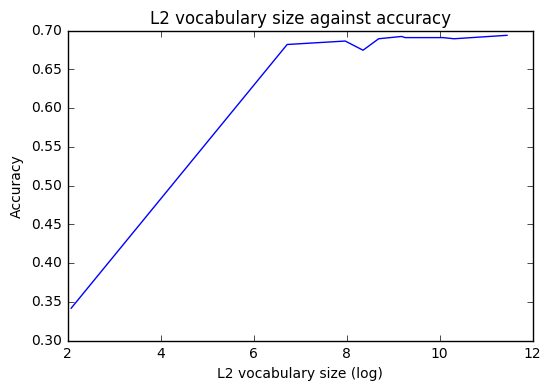

In [237]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    def get_nonzero_coef(coefs):
        '''Returns a (flat) list of non-zero coefficients'''
        def get_nonzero_coef_extract(coefs):
            '''Extract non-zero coefficients.'''
            return coefs.nonzero()[0]
        nonzero_features = map(lambda x: get_nonzero_coef_extract(x),coefs)
        nonzero_list = map(lambda x: nonzero_features[x].tolist(), range(len(coefs)))
        nonzero_flat = [i for sublist in nonzero_list for i in sublist]
        return nonzero_flat


    class LogisticRegressionFitter():
        '''Fit logistic regression models'''
    
        def __init__(self,train_data,train_labels,penalty_type,external_vocabulary=None,C_val=1,tol_val=0.0001):
            '''Instantiate a LogisticRegressionFitter object with or without an external vocabulary'''
            if external_vocabulary is None:
                self.vectorizer = CountVectorizer()
            else: 
                self.vectorizer = CountVectorizer(vocabulary=external_vocabulary)
            self.train_features = self.vectorizer.fit_transform(train_data)
            self.model = LogisticRegression(penalty=penalty_type,C=C_val,tol=tol_val)
            self.fit = self.model.fit(self.train_features,train_labels)
    
        @property
        def nonzero_coef_num(self):
            '''Number of nonzero coefficients'''
            coef_num = np.sum(map(lambda x: len(get_nonzero_coef(x)),self.fit.coef_))
            return coef_num
    
        def get_vocabulary(self):
            '''Returns vocabulary'''
            nonzero_flat = get_nonzero_coef(self.fit.coef_)
            # extract all of those weights which appear at least once
            nonzero_list = np.unique(nonzero_flat)
            nonzero_vocabulary = [self.vectorizer.get_feature_names()[index] for index in nonzero_list]
            return nonzero_vocabulary
        
        def get_accuracy(self,dev_data,dev_labels):
            '''Calculates accuracy'''
            dev_features = self.vectorizer.transform(dev_data)
            model_predicted = self.fit.predict(dev_features)
            accuracy = float(np.sum(model_predicted == dev_labels))/len(dev_labels)
            return accuracy

    # ------------------- start fitting ------------------ #
    # initialize parameter vector for penalty, save L2 vocabulary size and accuracy
    C_vals = [1e-3,0.1,0.5,1,2,5,10,50,100,1000]
    l2_vocab_size = []
    l2_accuracy = []
    # print C value, L1 vocabulary size, L2 vocabulary size and accuracy
    template = '|| {0:5} ||{1:5}|{2:6}|{3:8}|' 
    l2_base = LogisticRegressionFitter(train_data,train_labels,'l2')
    
    print 'Unrestricted L2 vocabulary size: {vs}\n\n'.format(vs=l2_base.nonzero_coef_num)

    for row in range(len(C_vals)+1):
        if row is 0:
            print template.format('C','L1 ','L2','Accuracy')
            print '-' * 33
        else:
            l1 = LogisticRegressionFitter(train_data,train_labels,'l1',C_val=C_vals[row-1],tol_val=0.01)
            new_vocab = l1.get_vocabulary()
            l2 = LogisticRegressionFitter(train_data,train_labels,'l2',C_val=C_vals[row-1],tol_val=0.01,
                                      external_vocabulary=new_vocab)
            l2_vocab_size.append(l2.nonzero_coef_num)
            l2_accuracy.append(l2.get_accuracy(dev_data,dev_labels))
            print template.format(C_vals[row-1], l1.nonzero_coef_num, l2_vocab_size[row-1],round(l2_accuracy[row-1],3))
    # -------------------------- plot --------------------------------- #
    plt.plot(np.log(l2_vocab_size), l2_accuracy)
    plt.ylabel('Accuracy') 
    plt.xlabel('L2 vocabulary size (log)')
    plt.title('L2 vocabulary size against accuracy')  
    plt.show() 
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [82]:
from sklearn.metrics import confusion_matrix

def P7():
    ### STUDENT START ###
    def get_R(probs,correct_label):
        '''Calculates ratio of of maximum predicted probability over the probability of the correct label'''
        return float(np.max(probs))/probs[correct_label]
    
    # if we could use pandas or itertools, I would 'group by' with a more explicit code
    def R_stat_by_label(labels,R):
        '''Prints mean and variance of R-ratios by labels'''
        R_label = []
        for label in range(len(np.unique(labels))): # loop through each category
            for label_num in range(len(labels)):  # by each label
                if labels[label_num] == label and R[label_num] is not 1: # when a mistake is made
                    R_label.append(R[label_num])        
            print 'Category: {cd}, R (mean): {Rm}, R (std): {Rv}'.format(cd=categories[label],Rm=np.mean(R_label),
                                                                    Rv=np.std(R_label))    
    
    # ------------- train model ----------------------- #
    vectorizer = TfidfVectorizer()
    train_features = vectorizer.fit_transform(train_data)
    dev_features = vectorizer.transform(dev_data)
    lr = LogisticRegression(C=100)
    lr.fit(train_features,train_labels)
    lr_predict_prob = lr.predict_proba(dev_features)
    pred_labels = lr.predict(dev_features)
    # ----------------- Model errors ----------------- #
    # calculate R-ratio for every document in the dev set
    R = map(get_R,lr_predict_prob,dev_labels)    
    index = np.argpartition(R, -3)[-3:]
    categories.sort()
    for rank in np.arange(len(index)-1,-1,-1):
        print 'Error rank: {rank}\n'.format(rank=-rank+len(index+1))
        print 'R-ratio: {r}\n'.format(r=R[index[rank]])
        print 'Observed category: {dev_cat}\n'.format(dev_cat=categories[dev_labels[index[rank]]])
        print 'Predicted category: {pred_cat}\n'.format(pred_cat=categories[pred_labels[index[rank]]])
        print 'Document text: \n\n {doc}\n'.format(doc=dev_data[index[rank]])
        print '*'*80
   
    print 'R-ratios given R > 1\n'
    print('Observed labels\n')
    R_stat_by_label(dev_labels,R)
    print('\nPredicted labels\n')
    R_stat_by_label(pred_labels,R)
        
    print '\nNormalized confusion matrix\n'
    cm = confusion_matrix(dev_labels,pred_labels)
    print cm.astype('float')/cm.sum(axis=1)


    ### STUDENT END ###
P7()

Error rank: 1

R-ratio: 929.358410854

Observed category: talk.religion.misc

Predicted category: comp.graphics

Document text: 

 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in

ANSWER: Per [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), tf-idf is not only a simple count of the expressions in a document but it also takes into the frequency of the occurrence of the expression in the corpus into account.

The largest R-ratios are associated with those religious topics that are categorized as computer graphics. Probably this occurs because of technical words such ftp, email or online that these examples include. However, if we look at the normalized confusion matrix, we can see that most of the misclassifications occur between the atheistic and religious topics which could be expected to be related, and only 3% and 1.6% of the computer graphics examples are classified as atheist or religious, respectively.

When looking at the R-ratios of the misclassified examples in more detail, we can see again that atheistic and religious topics have the highest mean R ratio and standard deviation if we group them by observed labels. However, when grouping by predicted labels, then computer graphics yields the highest mean and standard deviation, hinting at that when the real label is computer graphics, it is classified correctly, however, some of the predicted labels are classified as computer graphics with a high probability but they belong to other labels. 

A solution to this problem could be to identify those features which are not highly selective between the predicted categories and remove them from the model. For example, if some technical features are good predictors of computer graphics (high true positive rate) but are used often in other categories (high false positive rate), they might be removed from the model to increase the accuracy or other metric of prediction. 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

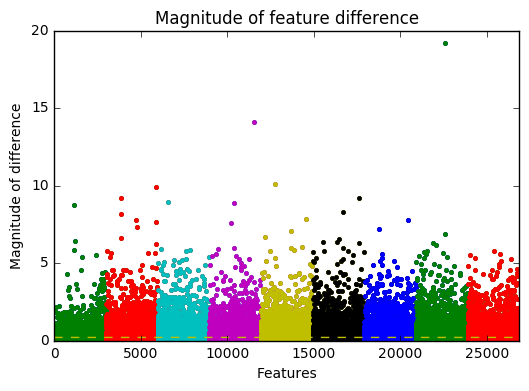

Magnitude of difference: the difference between the largest and second largest positive coefficient estimates
      of the labels by each feature. If the second largest is not positive, take the difference between the largest 
      and 0, if largest is not positive, let difference be 0.

Yellow dashed line indicates the median.

Improved vocabulary uses only the features with difference estimates over the median.

Original:

Vocabulary size: 26879
F1-score: 0.759766242785

Improved:

Vocabulary size: 13440
F1-score: 0.76406198252


In [197]:
from sklearn.metrics import f1_score


def get_difference(coefs):
    coefs.sort()
    if coefs[-1] > 0 and coefs[-2] > 0:
        diff = coefs[-1]-coefs[-2]
    elif coefs[-1] > 0:
        diff = coefs[-1]
    else:
        diff = 0 
    return diff



    # ------------- train model ----------------------- #
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_data)
orig_vocab_size = train_features.shape[1]
dev_features = vectorizer.transform(dev_data)
lr = LogisticRegression(C=100)
lr.fit(train_features,train_labels)
lr_predict_prob = lr.predict_proba(dev_features)
pred_labels = lr.predict(dev_features)
orig_f1 = f1_score(dev_labels,pred_labels,average='weighted')
# ----------------- Improve prediction ----------------- # 
# calculate the magnitude of the difference between the largest and second largest coefficient estimates of the labels
diffs=np.asarray(map(get_difference,lr.coef_.T))
# calculate median difference
median = np.percentile(diffs,q=50)
# ----------- Create a Manhattan plot-like scatter plot - #
index = np.asarray(range(len(lr.coef_[0])))
groups,step = np.linspace(0,np.max(index),10,retstep=True)
# http://stackoverflow.com/questions/37463184/how-to-create-a-manhattan-plot-with-matplotlib-in-python
for i in groups: 
    plt.plot(index[abs(index-i)<step],diffs[abs(index-i)<step],ls='', marker='.')
plt.xlim((0,np.max(index)))
horiz_line_data = np.array([median for i in xrange(len(index))])
plt.plot(index, horiz_line_data, 'y--') # add horizontal line for median
plt.title('Magnitude of feature difference')
plt.xlabel('Features')
plt.ylabel('Magnitude of difference')
plt.show()    
print '''Magnitude of difference: the difference between the largest and second largest positive coefficient estimates
      of the labels by each feature. If the second largest is not positive, take the difference between the largest 
      and 0, if largest is not positive, let difference be 0.\n'''
print 'Yellow dashed line indicates the median.\n' 
print 'Improved vocabulary uses only the features with difference estimates over the median.\n'
# ---------- Feature selection --------------------- #
# choose only features whose difference is larger than the median
important_features = np.where(diffs>=median)[0]
# extract vocabulary
important_vocabulary = [vectorizer.get_feature_names()[ind] for ind in important_features]
# refit model with the restricted vocabulary
vectorizer = TfidfVectorizer(vocabulary=important_vocabulary)
train_features = vectorizer.fit_transform(train_data)
dev_features = vectorizer.transform(dev_data)
lr = LogisticRegression(C=100)
lr.fit(train_features,train_labels)
lr_predict_prob = lr.predict_proba(dev_features)
pred_labels = lr.predict(dev_features)
f1 = f1_score(dev_labels,pred_labels,average='weighted')
# ------------ Print results --------------------- #
print "Original:\n"
print "Vocabulary size: {feat}".format(feat=orig_vocab_size)
print "F1-score: {f1s}\n".format(f1s=orig_f1)
print "Improved:\n"
print "Vocabulary size: {feat}".format(feat=train_features.shape[1])
print "F1-score: {f1s}".format(f1s=f1)


A measure of the importance of the coefficients are their magnitude. The logistic regression returns a 26789x4 matrix of coefficients for 26789 features for 4 labels. Consider each set of 4 coefficients of each feature by labels. Positive coefficients increase the probability that an example would belong to a label, negative coefficients would decrease it. If we would like to increase the probability that the label would be predicted, we can choose to consider only the positive coefficients. Let $d_i$ denote the difference for the ith feature and $c_{i,(\cdot)}$ the order statistics of the coefficients of the ith feature, then


$d_i = \begin{cases} c_{i,(1)}-c_{i,(2)}, & \text{if } c_{i,(1)},c_{i,(2)}>0\\
                    c_{i,(1)} & \text{if } c_{i,(1)}>0, c_{i,(2)} \leq 0\\
                       0, & \text{if } c_{i,(1)} \leq 0\end{cases}\,.$
                       
Keeping only those features where $d_i$ is greater than or equal the the median $d_i$ increases the F1-score of the prediction slightly. Instead of the median, we could use any other percentile; I tried with the 75th and 25th, but the median worked the best.